# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [39]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        #hv = CountVectorizer() #189777
        #hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False) #131074
        hv = HashingVectorizer(n_features=2 ** 10, alternate_sign=False, ngram_range = (1,2))
        #hv = HashingVectorizer(n_features=2 ** 9, alternate_sign=False) # 514
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        #sc = MinMaxScaler()
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [ ]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./mats/toxiccomments_train.csv', my_random_seed=15)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

# SVC with Different  Regularizations

In [43]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

SVC_4 = SVC(C = 1e-4, max_iter=1000)
SVC_4.fit(X_train, y_train)

SVC_4_performance_train_1 = BinaryClassificationPerformance(SVC_4.predict(X_train), y_train, 'SVC_4_train')
SVC_4_performance_train_1.compute_measures()
print(SVC_4_performance_train_1.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 12741, 'TN': 13005, 'FP': 101651, 'FN': 259, 'Accuracy': 0.2016826471141192, 'Precision': 0.11138016644520596, 'Recall': 0.9800769230769231, 'desc': 'SVC_4_train'}


In [44]:
SVC_3 = SVC(C = 1e-3, max_iter=1000)
SVC_3.fit(X_train, y_train)

SVC_3_performance_train = BinaryClassificationPerformance(SVC_3.predict(X_train), y_train, 'SVC_3_train')
SVC_3_performance_train.compute_measures()
print(SVC_3_performance_train.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 12855, 'TN': 6609, 'FP': 108047, 'FN': 145, 'Accuracy': 0.15247226922353826, 'Precision': 0.10632578451969364, 'Recall': 0.9888461538461538, 'desc': 'SVC_3_train'}


In [45]:
SVC_2 = SVC(C = 1e-2, max_iter=1000)
SVC_2.fit(X_train, y_train)

SVC_2_performance_train = BinaryClassificationPerformance(SVC_2.predict(X_train), y_train, 'SVC_2_train')
SVC_2_performance_train.compute_measures()
print(SVC_2_performance_train.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 12666, 'TN': 13116, 'FP': 101540, 'FN': 334, 'Accuracy': 0.20196465501034028, 'Precision': 0.11090485613715567, 'Recall': 0.9743076923076923, 'desc': 'SVC_2_train'}


In [47]:
SVC_1 = SVC(C = 1e-1, max_iter=1000)
SVC_1.fit(X_train, y_train)

SVC_1_performance_train = BinaryClassificationPerformance(SVC_1.predict(X_train), y_train, 'SVC_1_train')
SVC_1_performance_train.compute_measures()
print(SVC_1_performance_train.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 9767, 'TN': 72951, 'FP': 41705, 'FN': 3233, 'Accuracy': 0.6479758099893463, 'Precision': 0.1897536524712465, 'Recall': 0.7513076923076923, 'desc': 'SVC_1_train'}


In [53]:
from sklearn.svm import SVC
SVC0 = SVC(C = 1, max_iter=1000)
SVC0.fit(X_train, y_train)

SVC0_performance_train = BinaryClassificationPerformance(SVC0.predict(X_train), y_train, 'SVC0_train')
SVC0_performance_train.compute_measures()
print(SVC0_performance_train.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 5740, 'TN': 95300, 'FP': 19356, 'FN': 7260, 'Accuracy': 0.7915021620605377, 'Precision': 0.2287217086388269, 'Recall': 0.44153846153846155, 'desc': 'SVC0_train'}


In [54]:
SVC1 = SVC(C = 10, max_iter=1000)
SVC1.fit(X_train, y_train)

SVC1_performance_train = BinaryClassificationPerformance(SVC1.predict(X_train), y_train, 'SVC1_train')
SVC1_performance_train.compute_measures()
print(SVC1_performance_train.performance_measures)

/Users/chooseimage/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 6757, 'TN': 87552, 'FP': 27104, 'FN': 6243, 'Accuracy': 0.7387745190198659, 'Precision': 0.19955110599214435, 'Recall': 0.5197692307692308, 'desc': 'SVC1_train'}


### ROC plot to compare performance of various models and fits

/var/folders/qn/rnhppd716mvg1dm26kjg8jyc0000gn/T/ipykernel_44847/2279237540.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'],


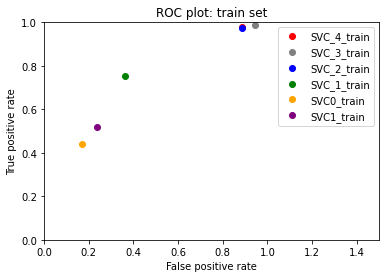

In [70]:
fits = [SVC_4_performance_train_1, SVC_3_performance_train, SVC_2_performance_train, SVC_1_performance_train, SVC0_performance_train, SVC1_performance_train]
colors = ['red','gray','blue','green','orange','purple']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1.5, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


In [58]:
SVC_4_test = BinaryClassificationPerformance(SVC_4.predict(X_test), y_test, 'SVC_4_test')
SVC_4_test.compute_measures()
print(SVC_4_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 3170, 'TN': 3214, 'FP': 25476, 'FN': 55, 'Accuracy': 0.20003133322888925, 'Precision': 0.11066117433498569, 'Recall': 0.9829457364341085, 'desc': 'SVC_4_test'}


In [59]:
SVC_3_test = BinaryClassificationPerformance(SVC_3.predict(X_test), y_test, 'SVC_3_test')
SVC_3_test.compute_measures()
print(SVC_3_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 3195, 'TN': 1574, 'FP': 27116, 'FN': 30, 'Accuracy': 0.1494281685727714, 'Precision': 0.105407277885916, 'Recall': 0.9906976744186047, 'desc': 'SVC_3_test'}


In [60]:
SVC_2_test = BinaryClassificationPerformance(SVC_2.predict(X_test), y_test, 'SVC_2_test')
SVC_2_test.compute_measures()
print(SVC_2_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 3138, 'TN': 3247, 'FP': 25443, 'FN': 87, 'Accuracy': 0.20006266645777848, 'Precision': 0.10979321927154403, 'Recall': 0.9730232558139534, 'desc': 'SVC_2_test'}


In [61]:
SVC_1_test = BinaryClassificationPerformance(SVC_1.predict(X_test), y_test, 'SVC_1_test')
SVC_1_test.compute_measures()
print(SVC_1_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 2323, 'TN': 18133, 'FP': 10557, 'FN': 902, 'Accuracy': 0.6409525301582328, 'Precision': 0.18035714285714285, 'Recall': 0.7203100775193798, 'desc': 'SVC_1_test'}


In [65]:
SVC0_test = BinaryClassificationPerformance(SVC0.predict(X_test), y_test, 'SVC_0_test')
SVC0_test.compute_measures()
print(SVC0_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1191, 'TN': 23733, 'FP': 4957, 'FN': 2034, 'Accuracy': 0.7809493968353439, 'Precision': 0.19372153545868576, 'Recall': 0.36930232558139536, 'desc': 'SVC_0_test'}


In [66]:
SVC1_test = BinaryClassificationPerformance(SVC1.predict(X_test), y_test, 'SVC1_test')
SVC1_test.compute_measures()
print(SVC1_test.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1503, 'TN': 21656, 'FP': 7034, 'FN': 1722, 'Accuracy': 0.7256462478458405, 'Precision': 0.17605716293780016, 'Recall': 0.466046511627907, 'desc': 'SVC1_test'}


### ROC plot to compare performance of various models and fits

/var/folders/qn/rnhppd716mvg1dm26kjg8jyc0000gn/T/ipykernel_44847/3861934233.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'],


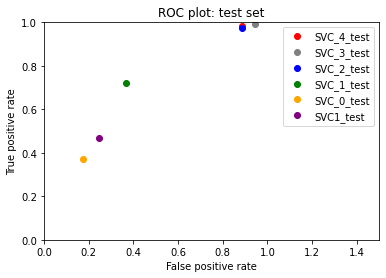

In [69]:
fits = [SVC_4_test,SVC_3_test, SVC_2_test, SVC_1_test, SVC0_test, SVC1_test]
colors = ['red','gray','blue','green','orange','purple']


for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1.5, 0.0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()